In [50]:
import torch
import pandas as pd
import pickle
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SkipGramFoo(torch.nn.Module):
  def __init__(self, voc, emb, ctx):
    super().__init__()
    self.ctx = ctx
    self.emb = torch.nn.Embedding(num_embeddings=voc, embedding_dim=emb)
    self.ffw = torch.nn.Linear(in_features=emb, out_features=voc, bias=False)
    self.sig = torch.nn.Sigmoid()

  # def forward(self, inpt, trgs, rand):
  #   emb = self.emb(inpt)
  #   ctx = self.ffw.weight[trgs]
  #   rnd = self.ffw.weight[rand]
  #   out = torch.mm(ctx, emb.T)
  #   rnd = torch.mm(rnd, emb.T)
  #   out = self.sig(out).clamp(min=1e-7, max=1 - 1e-7)
  #   rnd = self.sig(rnd).clamp(min=1e-7, max=1 - 1e-7)
  #   pst = -out.log().mean()
  #   ngt = -(1 - rnd).log().mean()
  #   return pst + ngt

#new forwarding for batch size 
  def forward(self, inpt, trgs, rand):
    # Embedding lookup for input (shape: [batch_size, embedding_dim])
    emb = self.emb(inpt)
    
    # Ensure context (trgs) and random samples (rand) have the same batch size as inpt
    batch_size = inpt.size(0)  # Get the current batch size

    # Slice or generate the random tensor according to the input batch size
    rand = rand[:batch_size]  # Adjust random tensor to match current batch size
    
    ctx = self.ffw.weight[trgs.to(inpt.device)]  # Shape: [batch_size, 2, embedding_dim]
    rnd = self.ffw.weight[rand.to(inpt.device)]  # Shape: [batch_size, 2, embedding_dim]

    # Ensure the batch size matches before performing batch matrix multiplication
    assert ctx.size(0) == emb.size(0), f"Context batch size {ctx.size(0)} doesn't match embeddings batch size {emb.size(0)}"
    assert rnd.size(0) == emb.size(0), f"Random batch size {rnd.size(0)} doesn't match embeddings batch size {emb.size(0)}"
    
    # Perform batch matrix multiplication
    out = torch.bmm(ctx, emb.unsqueeze(2)).squeeze(2)  # Shape: (batch_size, 2)
    rnd = torch.bmm(rnd, emb.unsqueeze(2)).squeeze(2)  # Shape: (batch_size, 2)
    
    # Apply sigmoid and clamp to prevent NaNs
    out = self.sig(out).clamp(min=1e-7, max=1 - 1e-7)
    rnd = self.sig(rnd).clamp(min=1e-7, max=1 - 1e-7)

    # Calculate loss
    pst = -out.log().mean()   # Positive sample log-likelihood
    ngt = -(1 - rnd).log().mean()  # Negative sample log-likelihood
    
    return pst + ngt

In [10]:
if mFoo.emb is None:
    raise ValueError("Embedding layer is not initialized.")


In [51]:
valid_titles_df = pd.read_csv('valid_titles_80_scores')
valid_titles_df.shape

(1231284, 2)

In [147]:
import pandas as pd
import torch
import pickle

# Check if GPU is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the updated vocabulary
with open('vocab_dict.pkl', 'rb') as fp:
    updated_vocab = pickle.load(fp)

# Step 1: Load the dataframe
valid_titles_df = pd.read_csv('valid_titles_80_scores')  # Assuming the file is valid_titles.csv
titles = valid_titles_df['title_cleaned'].tolist()

# Function to create a reverse vocabulary from the updated vocabulary
def create_reverse_vocab(vocab):
    return {word: index for index, word in vocab.items()}

# Load the reverse vocabulary
reverse_vocab = create_reverse_vocab(updated_vocab)

# Tokenize the titles using the reverse vocabulary
def tokenize_titles(titles, reverse_vocab):
    tokens = []
    
    for title in titles:
        words = title.lower().split()  # Convert the title to lowercase to match training preprocessing
        
        tokenized = []
        for word in words:
            if word in reverse_vocab:
                tokenized.append(reverse_vocab[word])  # Get the index from reverse_vocab
            # No else clause needed; unknown words are simply skipped
        
        tokens.append(tokenized)
    
    return tokens

# Now we use the reverse_vocab to tokenize the titles
tokenized_titles = tokenize_titles(titles, reverse_vocab)


# Step 3: Load the trained SkipGram model
model_path = "skipgram_model_titles.pth"
embedding_dim = 64  # Set to the same dimension used when training

# Ensure the model is moved to the GPU
mFoo = SkipGramFoo(len(updated_vocab), embedding_dim, 2).to(device)

# Load the saved model weights
mFoo.load_state_dict(torch.load(model_path))
mFoo.eval()  # Set the model to evaluation mode

# Step 4: Generate embeddings for each title
def get_embeddings_for_titles(tokenized_titles, model):
    embeddings_list = []
    
    with torch.no_grad():  # Disable gradient calculations for faster performance
        for tokens in tokenized_titles:
            if len(tokens) > 0:
                # Move the tokens to the GPU
                token_tensor = torch.LongTensor(tokens).to(device)
                
                # Get the embeddings for each token in the title
                token_embeddings = model.emb(token_tensor)  # Shape: [num_tokens, embedding_dim]
                
                # Average the token embeddings to get a single vector for the entire title
                title_embedding = token_embeddings.mean(dim=0)  # Shape: [embedding_dim]
                
                embeddings_list.append(title_embedding.cpu().numpy())  # Store the embedding as a NumPy array
            else:
                # Handle empty titles (if any)
                embeddings_list.append(torch.zeros(embedding_dim).cpu().numpy())  # Zero vector for empty titles
    
    return embeddings_list

# Generate embeddings for all the tokenized titles
embeddings = get_embeddings_for_titles(tokenized_titles, mFoo)

# Step 5: Store the embeddings
# Convert to a DataFrame for easier saving/processing later
embeddings_df = pd.DataFrame(embeddings)

# Save the embeddings to a file (optional)
embeddings_df.to_csv('title_embeddings.csv', index=False)


C:\Users\omare\AppData\Local\Temp\ipykernel_23060\157362959.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mFoo.load_state_dict(torch.load(model_path))


In [148]:
tokenized_titles

[[7, 419, 107, 342, 10, 2918],
 [109, 1341, 536, 66, 143, 2806, 1, 1035, 7912],
 [3494, 300],
 [328, 12416, 7499, 756, 763, 1341, 4, 4442],
 [1, 25, 638, 2, 1, 7052],
 [49, 269, 3, 2909, 648, 101, 2909, 617],
 [64, 1298, 15319],
 [359, 136, 438, 173, 1645, 5956, 49, 2904],
 [12568, 4891, 284, 2076],
 [1, 789, 2, 839, 1745, 20, 168, 5644],
 [1, 1448, 487, 281, 1755],
 [26414, 8138],
 [484, 38978],
 [6479, 239, 144, 1916, 4058, 10, 17480, 42, 3495, 2081, 10713],
 [20, 2479, 384, 392],
 [143, 482, 49, 31226, 650, 2109],
 [4886, 6483, 6, 5309, 3478, 94, 2, 1, 96, 58, 6769, 6586],
 [223, 796, 3, 1021, 15840, 6, 173, 6901, 1034, 3, 1310],
 [43, 3936, 882, 600, 530, 8845, 6, 1784, 2335, 5213],
 [4867, 12, 17569, 56, 27, 806, 44, 64346],
 [1470, 37, 3999, 421, 1958, 3282, 58, 11794, 16, 2607, 910],
 [1124, 10, 1, 901, 2, 245],
 [1, 4095, 1328, 795, 25336, 6, 7, 596, 49465],
 [409, 78, 1411, 6, 1223, 1841],
 [1160, 17691, 27, 450, 33, 2994],
 [2882, 123, 798, 2335, 13, 6381, 1304, 1859, 9504],


In [149]:
# Function to get the embedding of a specific word
def get_word_embedding(word, vocab, model):
    # Check if the word is in the vocabulary
    if word in reverse_vocab:
        index = reverse_vocab[word]  # Get the index of the word
        embedding = model.emb(torch.LongTensor([index]).to(device))  # Get the embedding for the word
        return embedding.detach().cpu().numpy()  # Detach and convert to NumPy array
    else:
        print(f"'{word}' not found in the vocabulary.")
        return None

# Example usage
word_to_inspect = "what"  # Replace with the word you want to inspect
embedding_vector = get_word_embedding(word_to_inspect, updated_vocab, mFoo)

if embedding_vector is not None:
    print(f"Embedding for '{word_to_inspect}': {embedding_vector}")



Embedding for 'what': [[ 0.44074917 -0.30176494 -0.41607687 -0.0878012   0.43704394 -0.6724253
   0.5014559  -0.92947763 -0.39647016  1.2727047  -0.09769747 -0.06923263
  -0.45475698  0.1573996  -0.15758702 -0.02607112 -0.40148208 -0.03070599
   0.1965615   0.5524046   0.8085856   0.26795807  0.27516386 -0.22690798
  -0.2845888   0.31643218  0.28090933 -0.22459322 -0.55772686  0.5850801
  -0.83067137  0.15475136 -0.6453265  -0.6860369   1.0594829  -0.23154312
   0.6355532   0.7737264   0.32928082  0.96605283  1.2200508   0.7165248
   0.11037972  0.04014343  0.10452028 -0.87080467  0.49196586  0.64406115
  -1.1156307   0.29073134  0.20857936  0.9940306   0.09512924 -0.37266222
  -0.24315526  0.20552295  0.00417871  0.01204656  0.07589839  0.9898188
   0.5909693  -0.6115431   0.40819883  0.4679865 ]]


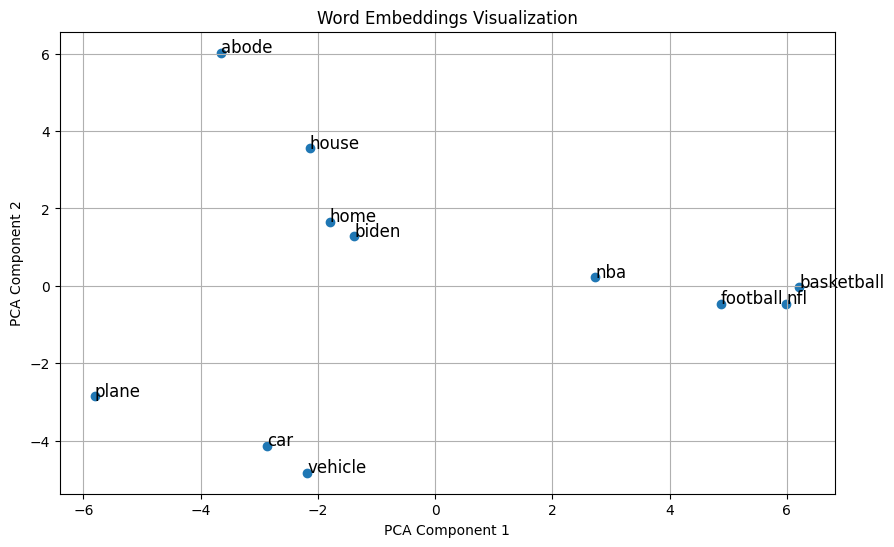

In [136]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Function to get embeddings for multiple words
def get_word_embeddings(words, vocab, model):
    embeddings = []
    for word in words:
        if word in reverse_vocab:
            index = reverse_vocab[word]
            embedding = model.emb(torch.LongTensor([index]).to(device)).detach().cpu().numpy()
            embeddings.append(embedding[0])  # Get the first (and only) element of the array
        else:
            print(f"'{word}' not found in the vocabulary.")
            embeddings.append(None)  # Placeholder for unknown words
    return embeddings

# Words to visualize
words_to_visualize = ["house", "home", "plane", "car", "nba", "nfl","football","vehicle","abode","basketball",
                      "biden"]  # Replace with your words

# Get embeddings for the selected words
embeddings = get_word_embeddings(words_to_visualize, updated_vocab, mFoo)

# Remove None values from embeddings
embeddings = [emb for emb in embeddings if emb is not None]

# Step 2: Reduce dimensionality using PCA or t-SNE
# Here, we're using PCA for simplicity, but you can also use t-SNE for better visualization
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Step 3: Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])

# Annotate points with corresponding words
for i, word in enumerate(words_to_visualize):
    if embeddings[i] is not None:
        plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=12)

plt.title('Word Embeddings Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid()
plt.show()


# Running model based on loaded in embeddings


In [56]:
embeddings_df.shape


(1231284, 64)

In [137]:
valid_titles_df

,Unnamed: 0,title_cleaned,domain,year,url,time,score,id,descendants
0,375051,a culture where change is ordinary,katalisha.com,2022,https://katalisha.com/devops/2021/08/26/idealc...,2022-01-25 02:24:12,2,30067098,0.0
1,375052,what americans lost when we abandoned the secr...,www.galioninquirer.com,2022,https://www.galioninquirer.com/opinion/72009/w...,2022-01-25 02:24:28,23,30067100,54.0
2,375053,extinct languages,en.wikipedia.org,2022,https://en.wikipedia.org/wiki/Extinct_language,2022-02-21 16:09:58,1,30417385,0.0
3,375054,our outdated marijuana laws put americans in d...,www.usatoday.com,2022,https://www.usatoday.com/story/opinion/2022/02...,2022-02-21 16:11:06,3,30417395,0.0
4,375056,the seven rules of the metaverse,medium.com,2021,https://medium.com/meta-verses/the-seven-rules...,2021-10-25 22:02:49,2,28993098,0.0
...,...,...,...,...,...,...,...,...,...
1231279,1875240,why i moved my startup to oakland,brennenbyrne.com,2013,http://brennenbyrne.com/2013/09/oakland/,2013-09-24 23:55:56,67,6441376,60.0
1231280,1875242,investment scam,medium.com,2015,https://medium.com/@englishpaulm/investment-sc...,2015-09-28 09:42:24,1,10289446,0.0
1231281,1875244,comparison between quill and other cassandra l...,github.com,2016,https://github.com/getquill/quill/blob/master/...,2016-02-19 20:13:01,1,11136262,0.0
1231282,1875245,get you ember fest ticket,emberfest.eu,2014,http://emberfest.eu/tickets,2014-04-24 07:19:05,1,7638755,0.0


In [126]:
y_train = valid_titles_df['score']

## data loader 

In [150]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
class Task_Dataset(Dataset):
    def __init__(self, embeddings_df: pd.DataFrame, y: np.ndarray):
        # Convert embeddings_df to tensor
        self.X = torch.tensor(embeddings_df.values).float()  # Convert DataFrame to tensor
        self.y = torch.from_numpy(y).float()  # Target labels, converted to tensor
        assert self.X.shape[0] == self.y.shape[0], "Embeddings and targets must have the same number of samples"

    def __len__(self):
        return self.X.shape[0]  # Return the number of samples

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]  # Return the embedding and the corresponding target

y_train = valid_titles_df['score'].to_numpy()
# Create dataset
task_ds = Task_Dataset(embeddings_df, y_train)

# Create dataloader
task_dl = DataLoader(task_ds, batch_size=512, shuffle=True)


## model


In [151]:
import torch
import torch.nn as nn

class SingleTask_Network(nn.Module):
    def __init__(self, input_dim: int = 64, hidden_dim_1: int = 300, hidden_dim_2: int = 200, hidden_dim_3: int = 150, hidden_dim_4: int = 100, hidden_dim_5: int = 50, output_dim: int = 1):
        super(SingleTask_Network, self).__init__()
        
        # First hidden layer
        self.hidden_1 = nn.Linear(input_dim, hidden_dim_1)
        # Second hidden layer
        self.hidden_2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        # Third hidden layer
        self.hidden_3 = nn.Linear(hidden_dim_2, hidden_dim_3)
        # Fourth hidden layer
        self.hidden_4 = nn.Linear(hidden_dim_3, hidden_dim_4)
        # Fifth hidden layer
        self.hidden_5 = nn.Linear(hidden_dim_4, hidden_dim_5)
        # Final output layer
        self.final = nn.Linear(hidden_dim_5, output_dim)

    def forward(self, x: torch.Tensor):
        # Pass through each hidden layer with ReLU activation
        x = torch.relu(self.hidden_1(x))
        x = torch.relu(self.hidden_2(x))
        x = torch.relu(self.hidden_3(x))
        x = torch.relu(self.hidden_4(x))
        x = torch.relu(self.hidden_5(x))
        # Final output layer (no activation for regression)
        x = self.final(x)
        return x.squeeze() 


In [153]:
import torch
import torch.nn as nn

# Initialize the model
model = SingleTask_Network(input_dim=task_ds.X.shape[1], output_dim=1)  # Using task_ds.X for input dimension

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Loss function: Use MSELoss for regression
loss_fn = nn.MSELoss()

In [156]:
import wandb
from tqdm import tqdm

# Initialize W&B
wandb.init(project="singletask_training", entity="omareweis123", name='batch_size(512)') # Replace with your project and entity names

# Number of epochs for training
num_epochs = 50

# Training loop
for epoch in range(num_epochs):
    epoch_loss = 0.0  # To calculate average loss for the epoch

    # Create a tqdm progress bar for the entire epoch
    with tqdm(total=len(task_dl), desc=f"Epoch {epoch + 1}/{num_epochs}", leave=False) as pbar:
        for j, (batch_X, batch_y) in enumerate(task_dl):
            # Forward pass
            preds = model(batch_X)
            
            # Compute loss
            loss = loss_fn(preds, batch_y)
            epoch_loss += loss.item()  # Accumulate loss
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update the progress bar with the current loss
            pbar.set_postfix(loss=loss.item())
            pbar.update(1)  # Increment the progress bar
            
            # Log the batch loss to W&B
            wandb.log({'Batch Loss': loss.item()})

    # Calculate average loss for the epoch
    avg_loss = epoch_loss / len(task_dl)
    
    # Log average loss for the epoch to W&B
    wandb.log({'Average Epoch Loss': avg_loss})

    # Optional: Print the final loss for the epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], Final Loss: {avg_loss:.4f}")

# Finish W&B logging
wandb.finish()





Batch Loss,▄▂▃▃▂▁▂▂▂▂▃▂▂▃▁▃▂▂▂▅▁▃█▂▆▂▇▄█▄▂▄▅▁▂▂▂▂▂▂
Batch Loss,4698.14795


In [155]:
# Save the model after training
model_save_path = "regression_20epochs_titles.pth"  # You can name the file as you like
torch.save(mFoo.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to regression_20epochs_titles.pth


In [114]:
for batch in task_dl:
    movie_batch_X, movie_batch_y = batch
    print(f"Batch shape: {movie_batch_X.shape}, Targets shape: {movie_batch_y.shape}")

    # Forward pass
    movie_preds = model(movie_batch_X)
    print(f"Predictions shape: {movie_preds.shape}")

Batch shape: torch.Size([50, 64]), Targets shape: torch.Size([50])
Predictions shape: torch.Size([50, 1])


## configuring multitask model 

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
class Task_Dataset(Dataset):
    def __init__(self, embeddings_df: pd.DataFrame, y: np.ndarray):
        # Convert embeddings_df to tensor
        self.X = torch.tensor(embeddings_df.values).float()  # Convert DataFrame to tensor
        self.y = torch.from_numpy(y).float()  # Target labels, converted to tensor
        assert self.X.shape[0] == self.y.shape[0], "Embeddings and targets must have the same number of samples"

    def __len__(self):
        return self.X.shape[0]  # Return the number of samples

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]  # Return the embedding and the corresponding target

y_train = np.random.randint(1, 501, size=embeddings_df.shape[0])
# Create dataset
task_ds = Task_Dataset(embeddings_df, y_train)

# Create dataloader
task_dl = DataLoader(task_ds, batch_size=512, shuffle=True)

In [31]:
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader

# Assuming the number of samples is the same as in task_ds
num_samples = embeddings_df.shape[0]

# Generate random years, for example between 2000 and 2023
random_years = np.random.randint(2000, 2024, size=num_samples)

# Convert the random years to a DataFrame
yelp_X_train = pd.DataFrame(random_years, columns=['Year'])

# Use the same y_train from the previous dataset
yelp_y_train = y_train  # y_train remains the same as in task_ds

# Create the new dataset for multi-task learning
yelp_ds = Task_Dataset(yelp_X_train, yelp_y_train)

# Create the DataLoader for the new dataset
yelp_dl = DataLoader(yelp_ds, batch_size=64, shuffle=True)

# Optional: Check the first few entries in the new dataset
print(yelp_X_train.head())
print(yelp_y_train[:5])  # Display first 5 entries of y_train


   Year
0  2000
1  2019
2  2013
3  2009
4  2020
[137 439 366 289  39]


In [32]:
import torch
import torch.nn as nn

class MultiTask_Network(nn.Module):
    def __init__(self, input_dim, 
                 output_dim_0: int = 1, output_dim_1: int = 1,  # Assuming output_dim_1 is for scores
                 hidden_dim: int = 200):
        
        super(MultiTask_Network, self).__init__()
        self.input_dim = input_dim
        self.output_dim_0 = output_dim_0
        self.output_dim_1 = output_dim_1
        self.hidden_dim = hidden_dim
        
        self.hidden = nn.Linear(self.input_dim, self.hidden_dim)
        self.final_0 = nn.Linear(self.hidden_dim, self.output_dim_0)  # For the regression task
        self.final_1 = nn.Linear(self.hidden_dim, self.output_dim_1)  # For the years to scores task     

    def forward(self, x: torch.Tensor, task_id: int):
        x = self.hidden(x)
        
        # Use ReLU or no activation (linear) for regression
        x = torch.relu(x)  # You can also choose to leave it linear (no activation)
        
        if task_id == 0:  # For task_ds
            x = self.final_0(x)  # Linear output for regression
        elif task_id == 1:  # For the years to scores task
            x = self.final_1(x)  # Linear output or another suitable activation
        else:
            assert False, 'Bad Task ID passed'
        
        return x


In [33]:
# Initialize the MultiTask_Network model
model = MultiTask_Network(input_dim=embeddings_df.shape[1],  # or movie_ds.X.shape[1]
                           output_dim_0=1,  # Single output for the regression task (task_ds)
                           output_dim_1=1)  # Single output for the scores task (yelp)

# Choose an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Use Mean Squared Error for both regression tasks
movie_loss_fn = nn.MSELoss()  # For task_ds regression
yelp_loss_fn = nn.MSELoss()    # For yelp scores regression


In [36]:
# Number of epochs for training
num_epochs = 6
losses_per_epoch = []

for epoch in range(num_epochs):
    epoch_loss = 0  # To track loss per epoch

    # Assuming task_dl returns both movie and yelp data
    for j, ((movie_batch_X, movie_batch_y), (yelp_batch_X, yelp_batch_y)) in enumerate(zip(task_dl, yelp_dl)):
        # Forward pass for movie task
        movie_preds = model(movie_batch_X, task_id=0)
        movie_loss = movie_loss_fn(movie_preds, movie_batch_y)

        # Ensure yelp input is correctly shaped
        yelp_batch_X = yelp_batch_X.float().view(-1, 1)  # Reshape if necessary
        
        # Forward pass for yelp task
        yelp_preds = model(yelp_batch_X, task_id=1)
        yelp_loss = yelp_loss_fn(yelp_preds, yelp_batch_y)  # Ensure yelp_batch_y is the correct target

        # Combined loss
        loss = movie_loss + yelp_loss
        epoch_loss += loss.item()  # Accumulate epoch loss
        losses_per_epoch.append(loss.item())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Optional: Print loss every few batches for monitoring
        if j % 100 == 0:  # Adjust this value as needed for how frequently you want to print
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{j + 1}/{len(task_dl)}], Loss: {loss.item():.4f}")

    # Log average loss for the epoch (optional)
    avg_loss = epoch_loss / len(task_dl)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Avg Loss: {avg_loss:.4f}")



RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x1 and 64x200)

RuntimeError: Could not infer dtype of builtin_function_or_method